In [1]:
import requests
import re
from bs4 import BeautifulSoup
import time
import selenium
from selenium import webdriver
import matplotlib.pyplot as plt
from selenium.common.exceptions import NoSuchElementException        
from selenium.common.exceptions import StaleElementReferenceException  
from datetime import datetime      
from urllib.parse import urlencode
from constants import Constant

# Set headers
headers = requests.utils.default_headers()
headers.update(
    {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})

params = {
    'category': Constant.category["DEFAULT"],
    'condition': [
        Constant.condition["NEW"],
        Constant.condition["USED"],
        Constant.condition["DEMO"]
        ],
    'priceMax': "",
    'priceMin': "",
    'tachometrMax': "",
    'yearMax': "",
    'yearMin': "",
    'manufacturer': Constant.manufacturer["BMW"],
    'model': Constant.model["BMW_M3"]
}

urls = [
    'https://www.sauto.cz/osobni/hledani#!' + urlencode(params, doseq=True)
]

driver = webdriver.Chrome()

def render_page(url):
    driver.get(url)
    time.sleep(3)
    r = driver.page_source
    return r

def return_int(value):
    return int(value.replace(" ", ""))

def get_date_time():
    now = datetime.now()
    return now.strftime("%Y-%m-%d %H:%M:%S")

r = render_page(urls[0])

soup = BeautifulSoup(r, "html.parser")

average = 0
value = ""
price = 0
sum_total = 0
items_total = 0
price_list_total = 0
manufacturer_list_total = []
model_list_total = []
mileage_list_total = []
year_manufactured_list_total = []
datetime_list_total = []

def scrape():
    sum = 0
    items = 0
    price_list = []
    manufacturer_list = []
    model_list = []
    mileage_list = []
    year_manufactured_list = []
    datetime_list = []
    for i in soup.select('.price strong:not(#pvContent .price strong)'):
        sum += return_int(i.text)
        manufacturer = driver.find_elements_by_css_selector(".carBoxContent h1")[0].text
        manufacturer_list.insert(items, manufacturer)
        model = driver.find_element_by_css_selector(".modelBox h1").text
        model_list.insert(items, model)
        yearManufactured = driver.find_elements_by_css_selector(".content dl")[items].find_elements_by_css_selector("dd")[1].text
        year_manufactured_list.insert(items, return_int(yearManufactured))
        mileage = driver.find_elements_by_css_selector(".content dl")[items].find_elements_by_css_selector("dd")[2].text
        mileage_list.insert(items, return_int(re.sub("[^\\d]", "", mileage)))
        datetime = get_date_time()
        datetime_list.insert(items, datetime)
        price_list.insert(items, return_int(i.text))
        items += 1
    result = (sum, items, price_list, manufacturer_list, model_list, mileage_list, year_manufactured_list, datetime_list)     
    return result

tuple = scrape()
sum_total = tuple[0]
items_total = tuple[1]
price_list_total = tuple[2]
manufacturer_list_total = tuple[3]
model_list_total = tuple[4]
mileage_list_total = tuple[5]
year_manufactured_list_total = tuple[6]
datetime_list_total = tuple[7]

def check_exists_by_cssSelector(css):
    try:
        driver.find_element_by_css_selector(css)
    except NoSuchElementException:
        return False
    except StaleElementReferenceException:
        return False
    return True

element_string = "#nextPage"

while check_exists_by_cssSelector(element_string):
    driver.find_element_by_css_selector(element_string).click()
    time.sleep(3)
    r = render_page(driver.current_url)
    soup = BeautifulSoup(r, "html.parser")
    tuple = scrape()
    sum_total += tuple[0]
    items_total += tuple[1]
    price_list_total += tuple[2]
    manufacturer_list_total += tuple[3]
    model_list_total += tuple[4]
    mileage_list_total += tuple[5]
    year_manufactured_list_total += tuple[6]
    datetime_list_total += tuple[7]

driver.quit()

average = sum_total / items_total

print("Items: " + str(items_total))
print("Min: " + str(min(price_list_total)))
print("Max: " + str(max(price_list_total)))
print("Average: " + str(average))
if average > 100000:
  print("Nikdy na to nebudes mit prachy voe")
else:
    print("Tak na tenhle vrak mas!")

Items: 24
Min: 429999
Max: 3350000
Average: 1248337.0
Nikdy na to nebudes mit prachy voe


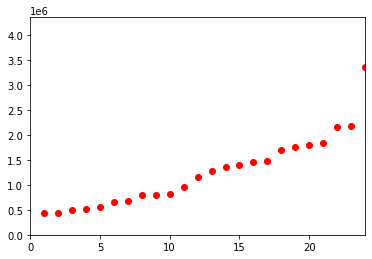

In [2]:
items_list_by_index = []
for (i, item) in enumerate(price_list_total, start=1):
    items_list_by_index.append(i)

plt.plot(items_list_by_index, price_list_total, 'ro')
plt.axis([0, items_total, 0, max(price_list_total) + 1000000])
plt.show()

In [3]:
import pandas as pd

data = {'manufacturer': manufacturer_list_total,
        'model': model_list_total,
        'price': price_list_total,
        'mileage': mileage_list_total,
        'year_manufactured': year_manufactured_list_total,
        'snaptime': datetime_list_total}

df = pd.DataFrame(data)

print(df)

manufacturer model    price  mileage  year_manufactured  \
0           BMW    M3   429999     2661               2017   
1           BMW    M3   440000   173542               2003   
2           BMW    M3   499000   240000               2003   
3           BMW    M3   519990   209000               2002   
4           BMW    M3   550000   200000               1998   
5           BMW    M3   649900   133000               1997   
6           BMW    M3   670000   129050               2007   
7           BMW    M3   786500   181000               2009   
8           BMW    M3   799000   112933               2010   
9           BMW    M3   819000   154295               2010   
10          BMW    M3   950000   177123               2009   
11          BMW    M3  1150000   123580               2015   
12          BMW    M3  1269000    49500               2014   
13          BMW    M3  1360000    92500               2014   
14          BMW    M3  1398200    24000               2016   
15         

(24, 6)
    mileage  year_manufactured    Price  Price_predict
0      2661               2017   429999        1778531
1    173542               2003   440000         606128
2    240000               2003   499000         403909
3    209000               2002   519990         451633
4    200000               1998   550000         292605
5    133000               1997   649900         449870
6    129050               2007   670000         927921
7    181000               2009   786500         863053
8    112933               2010   799000        1116772
9    154295               2010   819000         990915
10   177123               2009   950000         874850
11   123580               2015  1150000        1317391
12    49500               2014  1269000        1496199
13    92500               2014  1360000        1365358
14    24000               2016  1398200        1666997
15     2661               2017  1449999        1778531
16    44700               2016  1479000        1604011
17

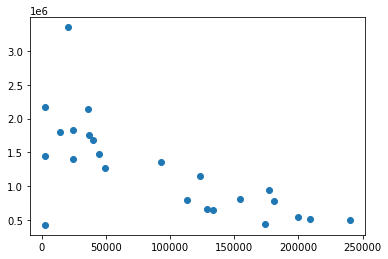

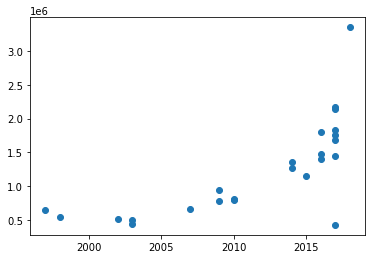

Coefficients: 
 [[-3.04281242e+00  4.66031632e+04]]
Mean squared error: 222974992711.80
Coefficient of determination: 0.54
[[594165.56890589]]


In [101]:
import sklearn
import numpy as np
print(df.shape)
df.describe()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#X = df.iloc[:, 3:5].values.reshape(-1, 1)  
X =df.loc[:, ['mileage', 'year_manufactured']] #.values #.reshape(-1, 1)  
Y = df.iloc[:, 2].values.reshape(-1, 1)  
linear_regressor = LinearRegression()  
linear_regressor.fit(X, Y) 
Y_pred = linear_regressor.predict(X)

Y_pred_df = pd.DataFrame({'Price_predict': Y_pred[:, 0]})
Y_df = pd.DataFrame({'Price': Y[:, 0]})
Y_dif = Y_df['Price'].sub(Y_pred_df['Price_predict'], axis = 0) 

pd.options.display.float_format = '{:,f}'.format
df_show =pd.concat([X.loc[:,'mileage'].reset_index(drop=True), X.loc[:,'year_manufactured'].reset_index(drop=True),Y_df.loc[:,:].reset_index(drop=True),Y_pred_df.loc[:,:].reset_index(drop=True)], axis=1)

print(round(df_show.astype(int),0))

plt.scatter(X.loc[:,'mileage'], Y)
#plt.plot(X.loc[:,'mileage'], Y_pred,color='r')
plt.show()

plt.scatter(X.loc[:,'year_manufactured'], Y)
#plt.plot(X.loc[:,'year_manufactured'], Y_pred,color='r')
plt.show()

print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

car_params = np.array([[300000, 2011]])
print(linear_regressor.predict(car_params))



In [94]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
features = np.array(X)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# The baseline predictions are the averages
baseline_preds = np.mean(Y)
print(baseline_preds)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
import graphviz
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph,) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#print(graph)
# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

#Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

car_params = np.array([[300000, 2011]])
print(rf.predict(car_params))

Training Features Shape: (18, 2)
Training Labels Shape: (18, 1)
Testing Features Shape: (6, 2)
Testing Labels Shape: (6, 1)
1248337.0
Average baseline error:  422029.17
Mean Absolute Error: 561825.42 degrees.
Accuracy: 24.93 %.
Variable: year_manufactured    Importance: 0.62
Variable: mileage              Importance: 0.38
[812841.71]
